0.007509732600795934
0.12437500710505044
3.136868967981997
4.599205802112369
[[0. 0. 0. ... 0. 0. 0.]
 [2. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 2.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


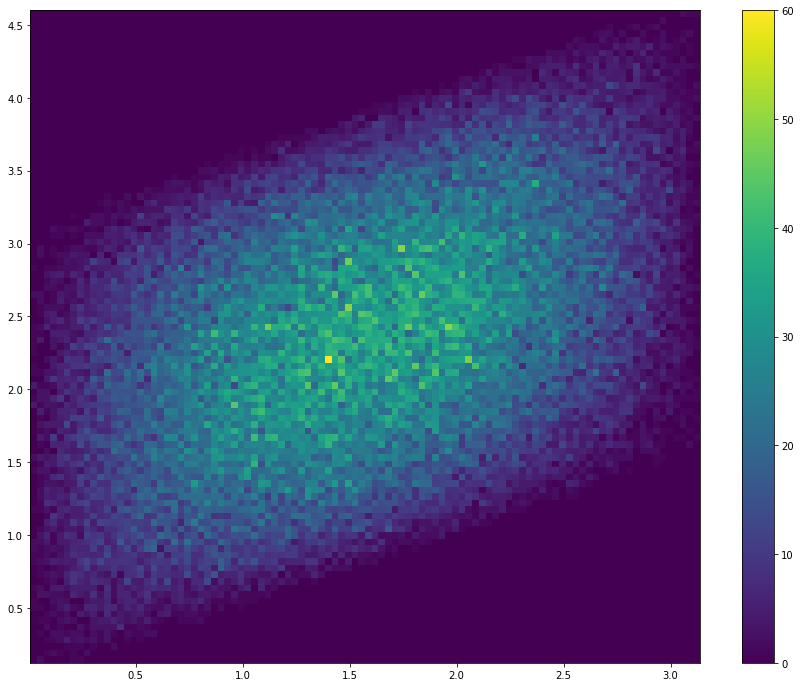

In [1]:
# try a 2d histogram for radiance
import numpy as np
import matplotlib.pyplot as plt

size = 100000
x = np.random.random(size)
x = np.arccos(x*2-1)
y = np.random.random(size)
y = np.arccos(y*2-1)
y = y + x/2
print(np.min(x))
print(np.min(y))

print(np.max(x))
print(np.max(y))


fig=plt.figure(figsize=[15,12])
(h, xedges, yedges, image) = plt.hist2d(x,y,bins=100)
print(h)
plt.colorbar()
plt.show()

In [2]:
# try a 4d histogram

import optics_cuda

source = optics_cuda.MonochromaticLambertianSource(0.001, 0.001, 555, 5e7, 0.001)
photons = source.make_photons(10000000)


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
import cupy as cp
import scipy.constants
bins = 10

points = (photons.r_x, photons.r_y, cp.arccos(photons.ez_z), cp.arctan2(photons.ez_y, photons.ez_x)) 
wavelength_m = photons.wavelength_nm * 1e-9
frequency_hz = scipy.constants.c / wavelength_m
energy_per_photon_j = scipy.constants.h * frequency_hz
energy_per_bundle_j = energy_per_photon_j * photons.photons_per_bundle
(h_j, edges) = cp.histogramdd(points, bins=(bins,bins,bins,bins), weights=energy_per_bundle_j, density=False)

# hack to see the total
waves = 40
h_j *= waves

In [4]:
# bins are 0.00005 m squares,  which should yield 2.5e-9 m^2 areas
bin_area_m2 = cp.outer(edges[0][1:] - edges[0][:-1] , edges[1][1:] - edges[1][:-1])
#print(bin_area_m2) # and it does

In [5]:
bin_area_sr = cp.outer(cp.cos(edges[2][:-1]) - cp.cos(edges[2][1:]) , edges[3][1:] - edges[3][:-1])

In [6]:
bin_area_sr_s_m2 = (bin_area_m2 * source._duration_s * bin_area_sr)

In [7]:
bin_area_sr_s_m2_stretched = bin_area_sr_s_m2[None,None,:,:]

In [8]:
radiance_per_bundle_per_angle_w_sr_m2  = h_j/bin_area_sr_s_m2_stretched

In [9]:
max_radiance_per_bundle_per_angle_w_sr_m2 = cp.amax(radiance_per_bundle_per_angle_w_sr_m2, axis=(2,3))
#print(max_radiance_per_bundle_per_angle_w_sr_m2)

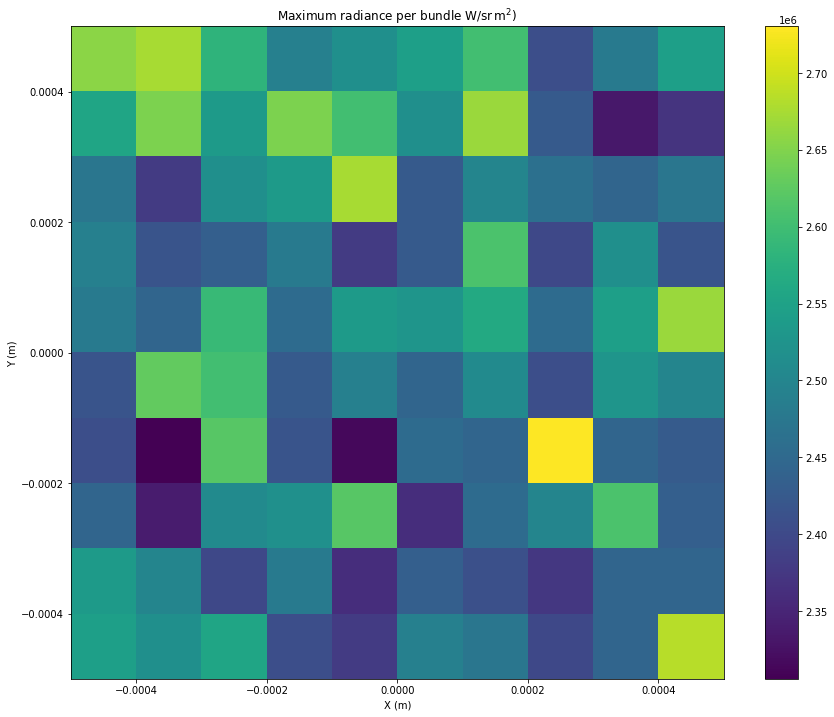

In [12]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=[15,12])
plt.imshow(max_radiance_per_bundle_per_angle_w_sr_m2.get(),# vmin=0,
           extent=(edges[0][0].item(), edges[0][-1].item(), edges[1][0].item(), edges[1][-1].item())) 
plt.title(r"Maximum radiance per bundle $\mathregular{W/sr\, m^2)}$")
plt.xlabel("X (m)")
plt.ylabel("Y (m)")

plt.colorbar()
plt.show()
# the expected number is like 2.5MW/sr/m2